In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

from sklearn.metrics import accuracy_score
from rouge import Rouge

import json
import os

from tqdm import tqdm




In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.wsd import lesk
for ss in wn.synsets('bank'):
    print(ss, ss.definition())

Synset('bank.n.01') sloping land (especially the slope beside a body of water)
Synset('depository_financial_institution.n.01') a financial institution that accepts deposits and channels the money into lending activities
Synset('bank.n.03') a long ridge or pile
Synset('bank.n.04') an arrangement of similar objects in a row or in tiers
Synset('bank.n.05') a supply or stock held in reserve for future use (especially in emergencies)
Synset('bank.n.06') the funds held by a gambling house or the dealer in some gambling games
Synset('bank.n.07') a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
Synset('savings_bank.n.02') a container (usually with a slot in the top) for keeping money at home
Synset('bank.n.09') a building in which the business of banking transacted
Synset('bank.n.10') a flight maneuver; aircraft tips laterally about its longitudinal axis (especially in turning)
Synset('bank.v.01') tip laterally
Sy

In [4]:
filename = 'image-description.json'
if os.path.exists(filename):
    with open(filename, 'r') as f:
        dictionary = json.load(f)

In [45]:
def predict_class_3(test_data, dictionary):
  generated_text_dict = dictionary
  generated_text_list = []
  global selected_col
  for img in range(1,11):
      selected_col = test_data[f'img{img}']

      
      if selected_col in generated_text_dict.keys():
        pred = generated_text_dict[selected_col]
        generated_text_list.append(pred)
      
      else:
        IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial_images_v1/"
        IMAGE_PATH_EACH = IMAGE_PATH + selected_col
        
        plot_img = Image.open(IMAGE_PATH_EACH)
        if plot_img.mode != "RGB":          #add this thing
          plot_img = plot_img.convert(mode="RGB")
          
          
        pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device)
        gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
        output_ids = model.generate(pixel_values, **gen_kwargs)
        pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        
        generated_text_dict[selected_col] = pred[0]
        generated_text_list.extend(pred)

  try:    
    word_description = lesk(word_tokenize(test_data['context']), test_data['keyword']).definition()

  except:
    new_reference_word = np.setdiff1d(test_data['context'].split(), test_data['keyword'].split())[0]
    word_description = lesk(word_tokenize(test_data['context']), new_reference_word)
    if word_description is None:
      output = 'No image'
      return output
      
    else:
      word_description = word_description.definition()
  

  rouge_score_list = []
  for i in range(10):
      rouge_score = rouge.get_scores(word_description, generated_text_list[i] )[0]['rouge-1']['p']
      rouge_score_list.append(rouge_score)
      

  predicted_image_idx = np.argmax(rouge_score_list)
  output = test_data[f'img{predicted_image_idx+1}']

  return output

In [11]:
PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/"
data = pd.read_csv(PATH+'trial.data.v1.txt', delimiter='\t', header=None)
keys = pd.read_csv(PATH+'trial.gold.v1.txt', delimiter='\t', header=None)
df = pd.concat([data, keys],axis=1)
df.columns = ['keyword', 'context', 'img1', 'img2', 'img3', 'img4', 'img5', 'img6', 'img7', 'img8', 'img9', 'img10', 'gold_key']
df.head()


,keyword,context,img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,gold_key
0,andromeda,andromeda tree,image.155.jpg,image.68.jpg,image.9.jpg,image.72.jpg,image.158.jpg,image.86.jpg,image.7.jpg,image.132.jpg,image.36.jpg,image.27.jpg,image.86.jpg
1,angora,angora city,image.5.jpg,image.52.jpg,image.96.jpg,image.70.jpg,image.46.jpg,image.91.jpg,image.76.jpg,image.139.jpg,image.14.jpg,image.115.jpg,image.70.jpg
2,anteater,marsupial anteater,image.147.jpg,image.16.jpg,image.107.jpg,image.135.jpg,image.93.jpg,image.59.jpg,image.88.png,image.131.jpg,image.89.jpg,image.121.jpg,image.107.jpg
3,bank,bank erosion,image.104.jpg,image.64.jpg,image.108.jpg,image.80.jpg,image.21.jpg,image.99.jpg,image.117.jpg,image.146.jpg,image.87.jpg,image.34.jpg,image.64.jpg
4,router,internet router,image.127.jpg,image.0.jpg,image.20.jpg,image.18.jpg,image.112.jpg,image.97.jpg,image.24.jpg,image.1.jpg,image.56.jpg,image.26.jpg,image.18.jpg


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

rouge = Rouge()

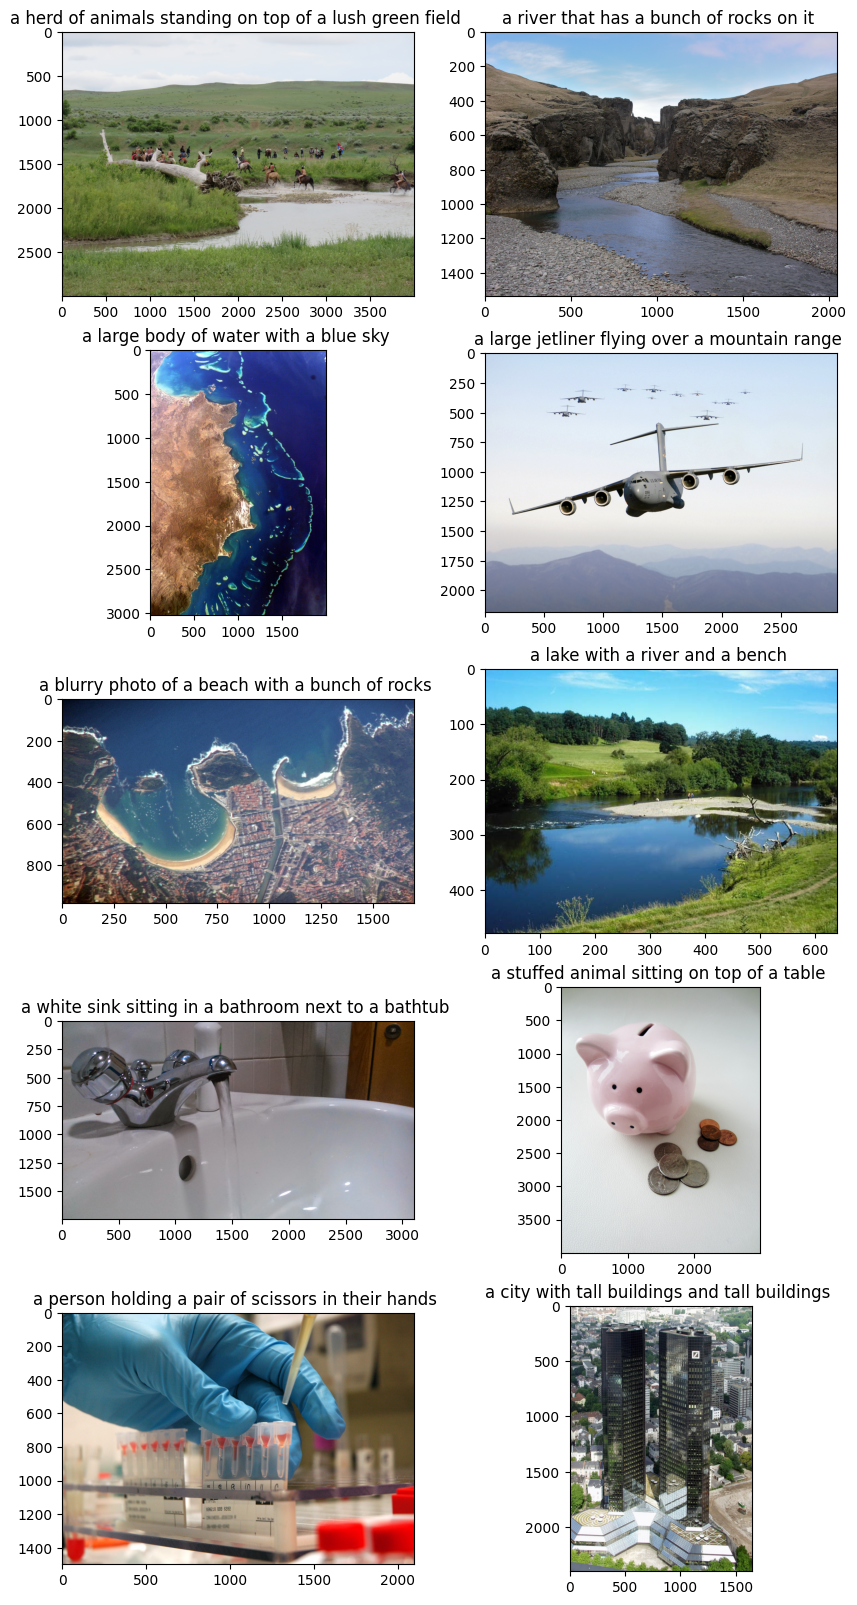

In [26]:
test_data = df.iloc[3]
generated_text_list = []


fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (10,20))

for img in range(1,11):
    selected_col = test_data[f'img{img}']
    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial_images_v1/"
    IMAGE_PATH_EACH = IMAGE_PATH + selected_col
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    axes.flatten()[img-1].imshow(plot_img)
    
    
    pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
    output_ids = model.generate(pixel_values, **gen_kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    axes.flatten()[img-1].title.set_text(pred[0])

    generated_text_list.extend(pred)

In [28]:
df.iloc[3]

keyword              bank
context      bank erosion
img1        image.104.jpg
img2         image.64.jpg
img3        image.108.jpg
img4         image.80.jpg
img5         image.21.jpg
img6         image.99.jpg
img7        image.117.jpg
img8        image.146.jpg
img9         image.87.jpg
img10        image.34.jpg
gold_key     image.64.jpg
Name: 3, dtype: object

In [29]:
word_description = lesk(word_tokenize(test_data['context']), test_data['keyword']).definition()
print(word_description)
rouge_score_list = []
for i in range(10):
    rouge_score = rouge.get_scores(word_description, generated_text_list[i] )[0]['rouge-1']['f']
    print(rouge_score)
    rouge_score_list.append(rouge_score)
    
print()
predicted_image_idx = np.argmax(rouge_score_list)
print(predicted_image_idx)

print(f"predicted img: {test_data[f'img{predicted_image_idx+1}']}")
print(f"true img: {test_data.gold_key}")

put into a bank account
0.13333332888888905
0.14285713826530627
0.1538461491124262
0.1666666618055557
0.1538461491124262
0.18181817685950424
0.14285713826530627
0.1538461491124262
0.14285713826530627
0.18181817685950424

5
predicted img: image.99.jpg
true img: image.64.jpg


In [46]:
result_list = []
for ind in tqdm(df.index):
    result = predict_class_3(test_data = df.loc[ind], dictionary= dictionary)
    result_list.append(result)

100%|██████████| 16/16 [00:00<00:00, 820.48it/s]


In [47]:
df['predicted_img'] = result_list
np.sum(df.gold_key == df.predicted_img)

0

: 

In [42]:
df

,keyword,context,img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,gold_key,predicted_img
0,andromeda,andromeda tree,image.155.jpg,image.68.jpg,image.9.jpg,image.72.jpg,image.158.jpg,image.86.jpg,image.7.jpg,image.132.jpg,image.36.jpg,image.27.jpg,image.86.jpg,image.72.jpg
1,angora,angora city,image.5.jpg,image.52.jpg,image.96.jpg,image.70.jpg,image.46.jpg,image.91.jpg,image.76.jpg,image.139.jpg,image.14.jpg,image.115.jpg,image.70.jpg,image.14.jpg
2,anteater,marsupial anteater,image.147.jpg,image.16.jpg,image.107.jpg,image.135.jpg,image.93.jpg,image.59.jpg,image.88.png,image.131.jpg,image.89.jpg,image.121.jpg,image.107.jpg,image.88.png
3,bank,bank erosion,image.104.jpg,image.64.jpg,image.108.jpg,image.80.jpg,image.21.jpg,image.99.jpg,image.117.jpg,image.146.jpg,image.87.jpg,image.34.jpg,image.64.jpg,image.99.jpg
4,router,internet router,image.127.jpg,image.0.jpg,image.20.jpg,image.18.jpg,image.112.jpg,image.97.jpg,image.24.jpg,image.1.jpg,image.56.jpg,image.26.jpg,image.18.jpg,image.112.jpg
5,stick,centre stick,image.100.jpg,image.62.jpg,image.156.jpg,image.78.jpg,image.122.jpg,image.81.jpg,image.148.jpg,image.114.jpg,image.123.jpg,image.55.jpg,image.156.jpg,image.81.jpg
6,swing,swing hit,image.51.jpg,image.141.jpg,image.11.jpg,image.77.jpg,image.95.jpg,image.33.jpg,image.65.jpg,image.113.jpg,image.53.jpg,image.54.jpg,image.54.jpg,image.113.jpg
7,tube,london tube,image.105.jpg,image.129.jpg,image.41.jpg,image.43.jpg,image.102.jpg,image.28.jpg,image.79.jpg,image.138.jpg,image.12.jpg,image.40.jpg,image.28.jpg,image.12.jpg
8,venus,venus surface,image.60.jpg,image.37.jpg,image.83.jpg,image.94.jpg,image.17.jpg,image.29.jpg,image.32.jpg,image.137.jpg,image.8.jpg,image.124.jpg,image.124.jpg,image.94.jpg
9,wheel,breaking wheel,image.111.jpg,image.69.jpg,image.82.jpg,image.73.jpg,image.74.jpg,image.48.jpg,image.140.jpg,image.118.jpg,image.50.jpg,image.157.jpg,image.118.jpg,image.74.jpg
